# Classification of Facial Characteristics Using CNN


---


### Introduction

Image recognition is one of the most important and exciting aspects of neural network technology. This ranges from determining the identity of a particular person in a crowd, to recognizing the emotion on a given face. This project will attempt to classify emotion from a known image dataset, the 10k US Adult Faces Database. This dataset can be found here:

http://www.wilmabainbridge.com/facememorability2.html

### Methodology



The original approach taken was to use pre-assigned labels given to some 2,222 of the datapoints by respondents to a survey. Each datapoint was labeled with, among other things, an emotion. The emotions fell into seven classes:

0 - Neutral
1 - Happy
2 - Sad
3 - Angry
4 - Scared
5 - Surprised
6 - Disgusted

The task was to use Convolutional Neural Network (CNN) analysis to classify the images by sex and by facial expression, using Keras with a TensorFlow back end. It was known from earlier studies that the VGG16 model had shown itself to be particularly effective at image recognition. 

Thus the original gameplan was to train an image classifier on these 2,222 datapoints. The problem with this approach was that, with regard to facial expression, there was a significant class imbalance in favor of classes 0 (neutral) and 1 (happy). 

The first remedy to this was to write a basic web scraper using Beautiful Soup, as will be shown later, in order to increase the numbers of the under-represented expression classes. Once the numbers of these classes had been increased, attempts were made to classify the images. Results were mixed, for either or both of two possible reasons:

1. the disparate nature of the images scraped.
2. Possibly inaccurate classifications by the survey respondents.

As such, the decision was made to trawl through the remaining 7,946 images that had not been pre-classified, and to find class exemplars among those to represent the under-balanced classes. Two of the classes, 'scared', and 'disgusted,' were dropped due to a dearth of available exemplars within the database. This resulted in a dataset of the following numbers, upon which the analysis began:

0 | Neutral
-------------
1 | Happy
-------------
2 | Sad
-------------
3 | Angry
-------------
4 | Surprised
--------------------


## The Analysis


---



In [1]:
!pip install image

In [2]:
# Import basic functions
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use(['seaborn-pastel'])
from PIL import Image
import image
import time
import shutil
from bs4 import BeautifulSoup
import requests

# Import various components for model building
# and interpretation of results
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau


#Import the backend
from keras import backend as K



Using TensorFlow backend.


In [3]:
# Import Google Drive, where the data are housed
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### System Details

Your will note from the above cell and from most of what follows in this notebook is hosted on Google Colabs. This was a decision taken midway through the project because the author's  own computer lacked sufficient power to perform some of the necessary computations in a practical timeframe. Thus, the switch was made to GPU-Assisted GPU runtimes.

### The Web Scraper

![alt text](https://arbisoft.com/static/media/uploads/icon-web-scraping.png)

As mentioned earlier, supplementary images were obtained from the web using Beautiful Soup, using a series of representative search strings in a number of languages. The scraper was configured to pull images straight from the web into a Google Drive. Yahoo Images seemed far more cooperative than Google Images, which did not lend itself to effective scraping and seemed to cause permission issues. Here the scraper is shown for the sake of completeness.

In [0]:
os.chdir('/content/drive/My Drive/app/emotionType/All/')

# Define the URLs from which the data will be scraped - Yahoo Images
fear_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrEzNxPqeRbo1YAgCOJzbkF?p=fear+human+face&ei=UTF-8&fr=yfp-t&imgty=photo&fr2=p%3As%2Cv%3Ai'
terrified_url = 'https://images.search.yahoo.com/search/images;_ylt=Awr9LtaKsORbGL8AiHCJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA0Q5UDNKakV3TGpLM0hzcUdXaUNIVkFLdE1qWXdNUUFBQUFCRzFEaUwEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkAzJfeG1qYTlUUWpTY1VjNmtVTUg4S0EEbXRlc3RpZANudWxsBG5fc3VnZwMwBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMyMARxdWVyeQN0ZXJyaWZpZWQgaHVtYW4gZmFjZQR0X3N0bXADMTU0MTcxNDA1NQR2dGVzdGlkA251bGw-?gprid=2_xmja9TQjScUc6kUMH8KA&pvid=D9P3JjEwLjK3HsqGWiCHVAKtMjYwMQAAAABG1DiL&p=terrified+human+face&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'

sadness_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExdlSqeRbYm0AeKeJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA1hwa1BlVEV3TGpLM0hzcUdXaUNIVkFPU01qWXdNUUFBQUFEWXBPVHIEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA3lGbFhuMi51Um5XX0c1RDBjRlhpR0EEbXRlc3RpZANudWxsBG5fc3VnZwMxMARvcmlnaW4DaW1hZ2VzLnNlYXJjaC55YWhvby5jb20EcG9zAzAEcHFzdHIDBHBxc3RybAMEcXN0cmwDMTQEcXVlcnkDc2FkIGh1bWFuIGZhY2UEdF9zdG1wAzE1NDE3MTIyNjMEdnRlc3RpZANudWxs?gprid=yFlXn2.uRnW_G5D0cFXiGA&pvid=XpkPeTEwLjK3HsqGWiCHVAOSMjYwMQAAAADYpOTr&p=sad+human+face&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'
miserable_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrEzODstuRbH1YADKyJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkAzBXRXJfVEV3TGpLM0hzcUdXaUNIVkFOX01qWXdNUUFBQUFDb01xWUgEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA1dWMjl2ZzN3VGhTaEkuVnJzOXJxbkEEbXRlc3RpZANudWxsBG5fc3VnZwMwBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMyMARxdWVyeQNtaXNlcmFibGUgaHVtYW4gZmFjZQR0X3N0bXADMTU0MTcxNTY4NAR2dGVzdGlkA251bGw-?gprid=WV29vg3wThShI.Vrs9rqnA&pvid=0WEr_TEwLjK3HsqGWiCHVAN_MjYwMQAAAACoMqYH&p=miserable+human+face&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'

disgust_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExo_dqeRb5wkAq.mJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA3ppOVVoVEV3TGpLM0hzcUdXaUNIVkFzWE1qWXdNUUFBQUFEZzl0elQEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA2NaRXk3ZURPU0NXSXdYQ3NwQW1pZ0EEbXRlc3RpZANudWxsBG5fc3VnZwMyBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMxOARxdWVyeQNkaXNndXN0IGh1bWFuIGZhY2UEdF9zdG1wAzE1NDE3MTIzNDIEdnRlc3RpZANudWxs?gprid=cZEy7eDOSCWIwXCspAmigA&pvid=zi9UhTEwLjK3HsqGWiCHVAsXMjYwMQAAAADg9tzT&p=disgust+human+face&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'
cara_de_asco_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExlRxyORbbHEARMqJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA2suSEdjREV3TGpLM0hzcUdXaUNIVkFuTk1qWXdNUUFBQUFDemdsdlcEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA0N0d0FMMUxEVEhpTVNPWjM3TGZvYUEEbXRlc3RpZANudWxsBG5fc3VnZwM5BG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMxMgRxdWVyeQNjYXJhIGRlIGFzY28EdF9zdG1wAzE1NDE3MjAxNzEEdnRlc3RpZANudWxs?gprid=CtwAL1LDTHiMSOZ37LfoaA&pvid=k.HGcDEwLjK3HsqGWiCHVAnNMjYwMQAAAACzglvW&p=cara+de+asco&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'

surprise_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExlR6zORb4SsAIUSJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA0pCLmdVREV3TGpLM0hzcUdXaUNIVkFGTE1qWXdNUUFBQUFEeEdCTTkEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA01hVmx1RlUuUk91X1VoUWUxeks1Q0EEbXRlc3RpZANudWxsBG5fc3VnZwMxBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMyMARxdWVyeQNzdXJwcmlzZWQgZmFjZSBodW1hbgR0X3N0bXADMTU0MTcyMTk4NwR2dGVzdGlkA251bGw-?gprid=MaVluFU.ROu_UhQe1zK5CA&pvid=JB.gUDEwLjK3HsqGWiCHVAFLMjYwMQAAAADxGBM9&p=surprised+face+human&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'
visage_surpris_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExdxmzORbU5cAaj6JzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkAzE2V1duREV3TGpLM0hzcUdXaUNIVkFGWE1qWXdNUUFBQUFEdjVvTkkEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA1NBNTN6MjRUU05TMzBGa09EMlBwa0EEbXRlc3RpZANudWxsBG5fc3VnZwMyBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMxNARxdWVyeQN2aXNhZ2Ugc3VycHJpcwR0X3N0bXADMTU0MTcyMTE5MQR2dGVzdGlkA251bGw-?gprid=SA53z24TSNS30FkOD2PpkA&pvid=16WWnDEwLjK3HsqGWiCHVAFXMjYwMQAAAADv5oNI&p=visage+surpris&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'

angry_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrExdmWz.RbCpQAi0GJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA1I4bHZ4akV3TGpLM0hzcUdXaUNIVkFkSk1qWXdNUUFBQUFBZ2poZDAEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA1FRdm91TTlVUVBxYTE0b19mTDZqU0EEbXRlc3RpZANudWxsBG5fc3VnZwMyBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMxNgRxdWVyeQNhbmdyeSBmYWNlIGh1bWFuBHRfc3RtcAMxNTQxNzIyNjA3BHZ0ZXN0aWQDbnVsbA--?gprid=QQvouM9UQPqa14o_fL6jSA&pvid=R8lvxjEwLjK3HsqGWiCHVAdJMjYwMQAAAAAgjhd0&p=angry+face+human&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'
mad_face_url = 'https://images.search.yahoo.com/search/images;_ylt=AwrEzNRL1eRbj4IASOOJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDYmU3bWFncGQyMTFxayUyNmIlM0QzJTI2cyUzRGs2BGNzcmNwdmlkA1g1aU1QakV3TGpLM0hzcUdXaUNIVkFVSU1qWXdNUUFBQUFCM3Bia1cEZnIDeWZwLXQEZnIyA3NhLWdwBGdwcmlkA1Z3MUhsaGdjUmcuZ0NPcVdWbFhvcEEEbXRlc3RpZANudWxsBG5fc3VnZwMxBG9yaWdpbgNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMxNARxdWVyeQNtYWQgZmFjZSBodW1hbgR0X3N0bXADMTU0MTcyMzQ2NAR2dGVzdGlkA251bGw-?gprid=Vw1HlhgcRg.gCOqWVlXopA&pvid=X5iMPjEwLjK3HsqGWiCHVAUIMjYwMQAAAAB3pbkW&p=mad+face+human&fr=yfp-t&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt&imgty=photo'

src = mad_face_url

r = requests.get(src)
html_content = r.text

soup = BeautifulSoup(html_content, 'html.parser')

x = soup.find_all('img')
y = [str(element) for element in x if 'http' in str(element)]

http_index = [element.index('http') for element in y]
y_final = [y[i][http_index[i]:].strip('"/>') for i in range(0,len(y))]

for page in y_final:
  filename = str(np.random.randint(1000,9999))
  result = requests.get(page, stream=True)
  if result.status_code == 200:
    image = result.raw.read()
    open(filename,"wb").write(image)

### The Scraped Images

Here we see a sampling of the images obtained.

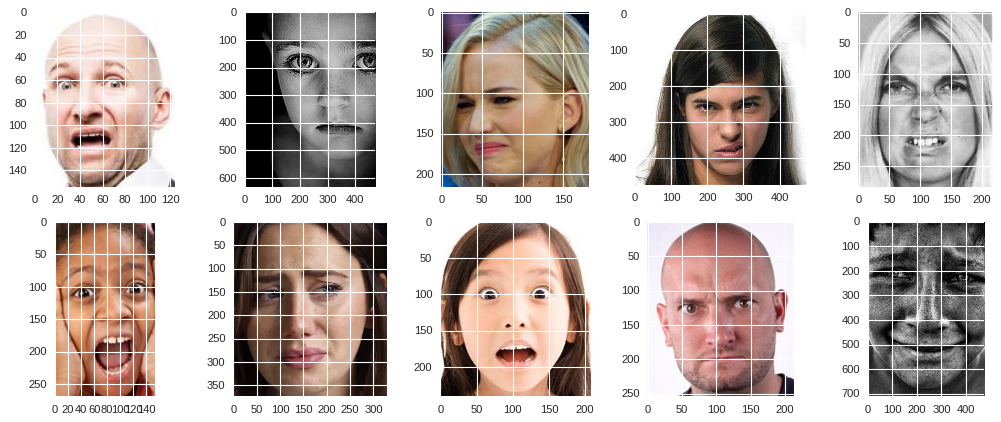

In [0]:
# Containing folder on Google Drive
folder = '/content/drive/My Drive/app/Face Images2/'

imgs = ['1003', '1015', '1023', '1073', '1103', '1135', '1394', '1506', '1966', '2372']

# Display a selection of the images
plt.rcParams['figure.figsize'] = (16.0, 6.0)
for i in range(len(imgs)):
  plt.subplot(2,5,i+1)
  imgpath = folder + imgs[i] + '.jpg'
  img = cv2.imread(imgpath, 1)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)
plt.show()

### The Change in Approach

As has been alluded to above, the initial analysis met with mixed results. The second approach incorporated the following changes:

1. The scraped images (a sample of which are shown above) were initially abandoned, due to large variations in quality and the non-uniformity of the poses. For example, in many of the images the subject had their hands around their face. Recall that the original dataset had over 10,000 facial images in it, most of which were unclassified.
2. The ground truth classifications of the facial expressions were done by the author to ensure consistency.
3. Instead of writing functions, the models were instantiated using the versions built into Keras.

### The Original Image Dataset

We now take a look at a sample of the original set of images it should be noted that these faces are considerably less expressive than the scraped ones that were removed.

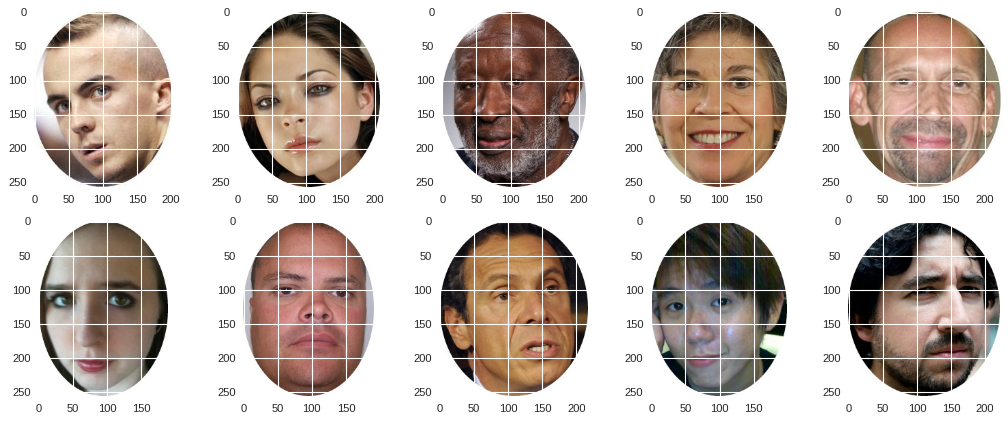

In [0]:
# A selection of filenames
imgs = ['Google_1_Claire Muniz_3_oval', 'Google_1_Kristin Catalan_7_oval', 'Google_1_Clarence Music_19_oval',
        'Google_1_Vincent Guest_7_oval', 'Google_1_Donald Mcclurg_16_oval', 'Google_1_Ernest Crump_3_oval',
        'Google_1_Frank Bivins_15_oval', 'Google_1_Jerry Lovelace_16_oval', 'Google_1_Judy Chao_11_oval',
        'Google_1_Kathy Gruber_19_oval']

# Display the corresponding images
plt.rcParams['figure.figsize'] = (16.0, 6.0)
for i in range(len(imgs)):
  plt.subplot(2,5,i+1)
  imgpath = folder + imgs[i] + '.jpg'
  img = cv2.imread(imgpath, 1)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)
plt.show()

## CNN Analysis


---


Given the small size of the dataset, the primary potential problem was that there were not enough data to be able effectively to train a CNN. However, there are a number of pre-trained models that can be used specifically on smaller datasets. This is known as Transfer Learning. One such pre-trained model is VGG16, so called because it consists of 16 layers. VGG16 was built for, and used in, the 2014 ImageNet competition, in which the task was to train a model to identify a 1000-class image dataset. In using VGG16 for another dataset, the training images can be reshaped to fit the VGG16 model, which expects input shape (224,224). Since the final layer of VGG16 has 1000 classes, this must be removed and our own layer added with 2 output classes for sex classification, and 4 or more for facial expressions.

### Data Augmentation

Another widely used measure to offset the small size of the dataset, is the use of data augmentation. This involves making small changes to the characteristics of each image, whether using small rotations or slight changes to the vertical and horizontal dimensions, to produce a new, slightly different image. By doing this, we will be able to reduce the effect of having a limited-size dataset. 

### Classification Based on Sex

![alt text](https://camo.githubusercontent.com/77189da1b5855fadf42ab441b7f5b27e70894e6e/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f612f61662f47656e6465725f73796d626f6c735f736964655f62795f736964655f736f6c69642e7376672f32353070782d47656e6465725f73796d626f6c735f736964655f62795f736964655f736f6c69642e7376672e706e67)

As a control on a less challenging task, the decision was made to do an initial classification using sex as the distinguishing criterion. Note that this was done on images obtained from the original dataset, excluding any scraped images.

In [0]:
# Define training, validation and test data paths
train_path = '/content/drive/My Drive/app/sex/trainAll/'
test_path = '/content/drive/My Drive/app/sex/testAll/'
valid_path = '/content/drive/My Drive/app/sex/valAll/'

train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224),classes=
                                                             ['0','1'],
                                                            batch_size=100, shuffle=True, class_mode='categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224),classes=
                                                             ['0','1'],
                                                            batch_size=100, shuffle=True, class_mode='categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=
                                                             ['0','1'],
                                                            batch_size=100, shuffle=False)

Found 1356 images belonging to 2 classes.
Found 444 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


### VGG16

In [0]:
 vgg16Model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 9s 0us/step


In [0]:
num_classes = 2
model = Sequential()

for layer in vgg16Model.layers[:-1]:
  model.add(layer)
  
for layer in model.layers:
  layer.trainable = False

model.add(Dense(2,activation='softmax'))  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
# Callback functions
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir="logs_2", write_graph=True, write_images=True)
early_stopper = EarlyStopping(monitor='val_loss',
                              mode='auto')
checkpoint = ModelCheckpoint('./models/model_2.h5')

In [0]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=14,
                   validation_data=valid_batches,
                   validation_steps=5, epochs=50,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/50
 - 418s - loss: 0.9937 - acc: 0.4382 - val_loss: 0.8321 - val_acc: 0.5315
Epoch 2/50
 - 21s - loss: 0.7156 - acc: 0.6021 - val_loss: 0.5600 - val_acc: 0.7410
Epoch 3/50
 - 27s - loss: 0.5373 - acc: 0.7236 - val_loss: 0.4554 - val_acc: 0.7928
Epoch 4/50
 - 26s - loss: 0.4347 - acc: 0.8006 - val_loss: 0.3888 - val_acc: 0.8311
Epoch 5/50
 - 27s - loss: 0.4112 - acc: 0.8239 - val_loss: 0.3542 - val_acc: 0.8514
Epoch 6/50
 - 27s - loss: 0.3680 - acc: 0.8528 - val_loss: 0.3329 - val_acc: 0.8671
Epoch 7/50
 - 26s - loss: 0.3499 - acc: 0.8523 - val_loss: 0.3245 - val_acc: 0.8559
Epoch 8/50
 - 27s - loss: 0.3350 - acc: 0.8628 - val_loss: 0.3067 - val_acc: 0.8761
Epoch 9/50
 - 27s - loss: 0.3202 - acc: 0.8684 - val_loss: 0.2948 - val_acc: 0.8851
Epoch 10/50
 - 27s - loss: 0.3173 - acc: 0.8793 - val_loss: 0.2881 - val_acc: 0.8829
Epoch 11/50
 - 27s - loss: 0.3166 - acc: 0.8688 - val_loss: 0.2804 - val_acc: 0.8874
Epoch 12/50
 - 27s - loss: 0.3096 - acc: 0.8784 - val_loss: 0.2743 - val_

In [0]:
def show_graphs(training):
  plt.plot(training.history['acc'])
  plt.plot(training.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(training.history['loss'])
  plt.plot(training.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

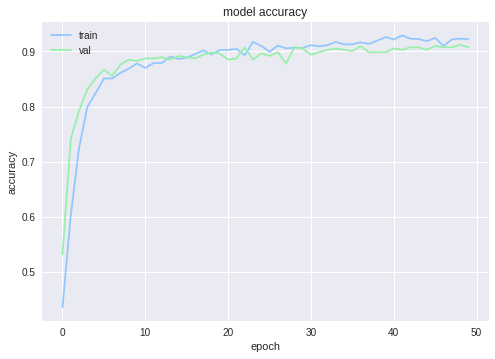

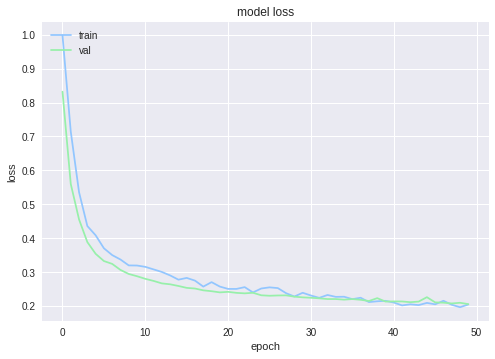

In [0]:
show_graphs(training)

In [0]:
predictions = model.predict_generator(test_batches, steps=5, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches.classes
agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.9004739336492891

In [0]:
score = model.evaluate_generator(test_batches, steps=5, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 0.24041692502973203
Test accuracy: 0.9004739296944786
************************************************************


In [0]:
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[160  32]
 [ 10 220]]
Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.04347826 0.95652174]]


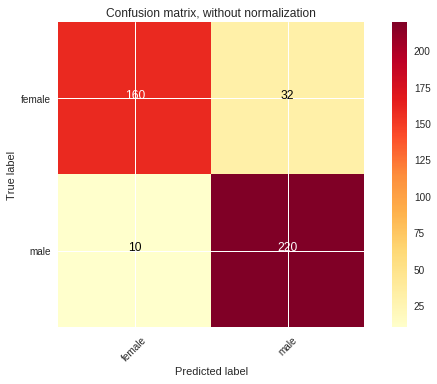

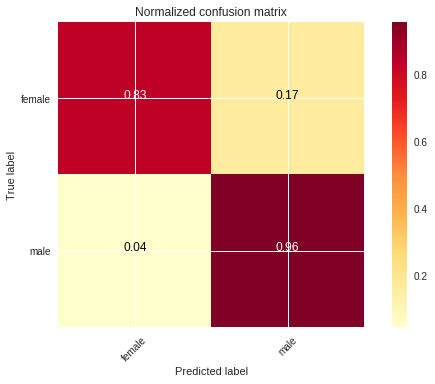

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['female', 'male']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

     female       0.94      0.83      0.88       192
       male       0.87      0.96      0.91       230

avg / total       0.90      0.90      0.90       422



### Discussion of Results

Thus the model achieved an impressive 87% accuracy in distinguishing between male and female faces. The visualized confusion matrix shows that the model is slightly more accurate in identifying male faces than female. In all, the results from this part of the analysis showed that the VGG16 model was properly configured and was responsive to the characteristics of the dataset. Having established this, attention could now be turned to the more challenging problem of identifying facial expressions. 

### Classification Based on Facial Expression

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSA0rRzNC2uFz9rrbHx7fQ2_AAdG0J_ki0AEFuFB2kos_Q5BHJ0)

Having established that the data pipeline was structured correctly and that the model was pulling and identifying images appropriately, attention was turned to the considerably more subjective and difficult task of emotion recognition. Here the images were separated into five classes: neutral, happy, sad, angry, and surprised. As before, data augmentation was used because the dataset was even smaller this time than previously. The training, test and validation file paths were modified to point to different pre-populated folders.

In [0]:
# Define training, validation and test data paths
train_path_e = '/content/drive/My Drive/app/emotionType/trainAllp/'
test_path_e = '/content/drive/My Drive/app/emotionType/testAllp/'
valid_path_e = '/content/drive/My Drive/app/emotionType/valAllp/'

# Data augmentation
train_datagen_e = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches_e = train_datagen_e.flow_from_directory(train_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
valid_batches_e = ImageDataGenerator().flow_from_directory(valid_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
test_batches_e = ImageDataGenerator().flow_from_directory(test_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=False)

Found 243 images belonging to 5 classes.
Found 85 images belonging to 5 classes.
Found 70 images belonging to 5 classes.


### VGG16

In [0]:
vgg16Model = keras.applications.vgg16.VGG16()

In [0]:
num_classes = 5
model_e = Sequential()

for layer in vgg16Model.layers[:-1]:
    model_e.add(layer)

for layer in model_e.layers:
  layer.trainable = False
model_e.add(Dense(num_classes,activation='softmax'))
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
model_e.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training_e = model_e.fit_generator(train_batches_e, steps_per_epoch=25,
                   validation_data=valid_batches_e,
                   validation_steps=9, epochs=50,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/50
 - 68s - loss: 2.3644 - acc: 0.2643 - val_loss: 1.7694 - val_acc: 0.2471
Epoch 2/50
 - 5s - loss: 1.8038 - acc: 0.2572 - val_loss: 1.7269 - val_acc: 0.3294
Epoch 3/50
 - 5s - loss: 1.6164 - acc: 0.3333 - val_loss: 1.6128 - val_acc: 0.4118
Epoch 4/50
 - 5s - loss: 1.4947 - acc: 0.4125 - val_loss: 1.5690 - val_acc: 0.4000
Epoch 5/50
 - 5s - loss: 1.4322 - acc: 0.4285 - val_loss: 1.4864 - val_acc: 0.4353
Epoch 6/50
 - 5s - loss: 1.3833 - acc: 0.4664 - val_loss: 1.5080 - val_acc: 0.4353
Epoch 7/50
 - 6s - loss: 1.3197 - acc: 0.4695 - val_loss: 1.5590 - val_acc: 0.4118
Epoch 8/50
 - 5s - loss: 1.2845 - acc: 0.5105 - val_loss: 1.4154 - val_acc: 0.4706
Epoch 9/50
 - 5s - loss: 1.2299 - acc: 0.5195 - val_loss: 1.4762 - val_acc: 0.4824
Epoch 10/50
 - 5s - loss: 1.2020 - acc: 0.5585 - val_loss: 1.4079 - val_acc: 0.4824
Epoch 11/50
 - 5s - loss: 1.1949 - acc: 0.5255 - val_loss: 1.4641 - val_acc: 0.4471
Epoch 12/50
 - 5s - loss: 1.1237 - acc: 0.5776 - val_loss: 1.5556 - val_acc: 0.4000


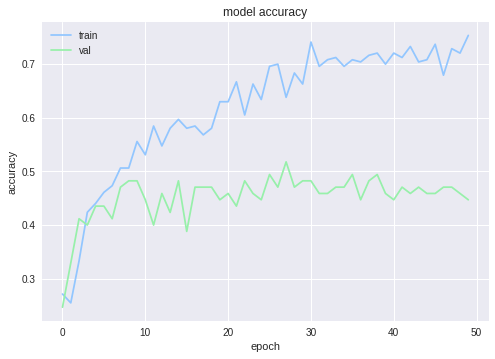

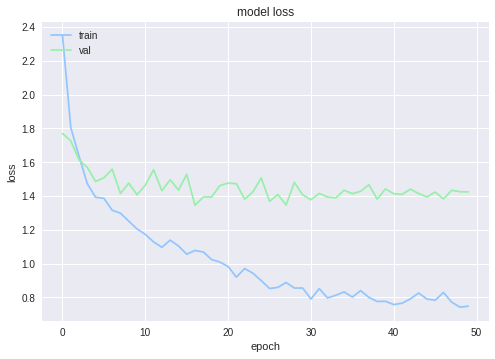

In [0]:
show_graphs(training_e)

In [0]:
predictions = model_e.predict_generator(test_batches_e, steps=7, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches_e.classes

agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.35714285714285715

In [0]:
score = model_e.evaluate_generator(test_batches_e, steps=7, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 1.6410883069038391
Test accuracy: 0.35714286246470045
************************************************************


Confusion matrix, without normalization
[[8 0 1 1 2]
 [7 9 1 3 2]
 [3 0 2 3 0]
 [9 2 1 4 2]
 [4 1 0 3 2]]
Normalized confusion matrix
[[0.66666667 0.         0.08333333 0.08333333 0.16666667]
 [0.31818182 0.40909091 0.04545455 0.13636364 0.09090909]
 [0.375      0.         0.25       0.375      0.        ]
 [0.5        0.11111111 0.05555556 0.22222222 0.11111111]
 [0.4        0.1        0.         0.3        0.2       ]]


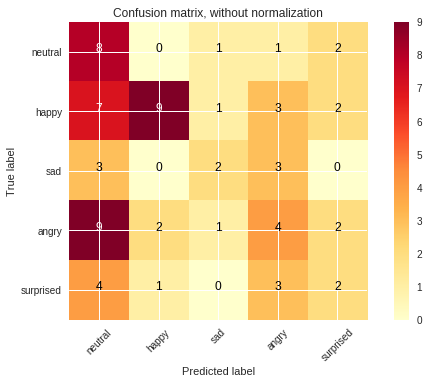

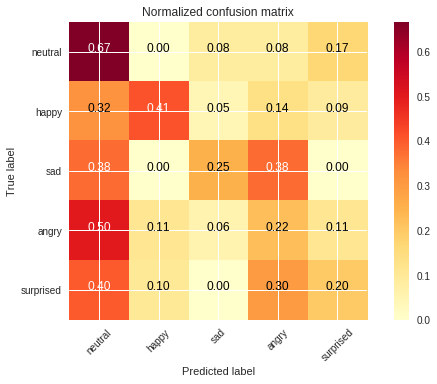

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['neutral', 'happy', 'sad', 'angry', 'surprised']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

    neutral       0.26      0.67      0.37        12
      happy       0.75      0.41      0.53        22
        sad       0.40      0.25      0.31         8
      angry       0.29      0.22      0.25        18
  surprised       0.25      0.20      0.22        10

avg / total       0.43      0.36      0.36        70



### Discussion of Results

At 41.4% the model accuracy is significantly lower than that achieved for sex identification. The model seems to perform well at identifying happy faces, but neutral faces seem to present a problem, with the recall being particularly poor. The first runs with this dataset (sex classification and now facial expresssion classification) were done without the scraped images, due to concerns over their quality and variability. Given the results from this first run on facial expression, the decision was made to add back the scraped images, since many of them had quite exaggerated expressions, and this might alleviate the clear problem with neutral expressions.

### Re-Run Model with Scraped Images Added Back

In [0]:
# Define training, validation and test data paths
train_path_e = '/content/drive/My Drive/app/emotionType/trainAllq/'
test_path_e = '/content/drive/My Drive/app/emotionType/testAllq/'
valid_path_e = '/content/drive/My Drive/app/emotionType/valAllq/'

# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches_e = train_datagen.flow_from_directory(train_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
valid_batches_e = ImageDataGenerator().flow_from_directory(valid_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
test_batches_e = ImageDataGenerator().flow_from_directory(test_path_e, target_size=(224,224),classes=
                                                             ['0','1','2','3','4'],
                                                            batch_size=10, shuffle=False)

Found 327 images belonging to 5 classes.
Found 115 images belonging to 5 classes.
Found 70 images belonging to 5 classes.


In [0]:
vgg16Model = keras.applications.vgg16.VGG16()

In [0]:
num_classes = 5
model_e = Sequential()

for layer in vgg16Model.layers[:-1]:
  model_e.add(layer)

for layer in model_e.layers:
  layer.trainable = False
model_e.add(Dense(num_classes,activation='softmax'))
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
model_e.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training_e = model_e.fit_generator(train_batches_e, steps_per_epoch=33,
                   validation_data=valid_batches_e,
                   validation_steps=12, epochs=25,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/25
 - 86s - loss: 2.0670 - acc: 0.2341 - val_loss: 1.7681 - val_acc: 0.3130
Epoch 2/25
 - 7s - loss: 1.6530 - acc: 0.3008 - val_loss: 1.5384 - val_acc: 0.3652
Epoch 3/25
 - 7s - loss: 1.4841 - acc: 0.3857 - val_loss: 1.4581 - val_acc: 0.4261
Epoch 4/25
 - 8s - loss: 1.3881 - acc: 0.4329 - val_loss: 1.4139 - val_acc: 0.4696
Epoch 5/25
 - 7s - loss: 1.2661 - acc: 0.4749 - val_loss: 1.3209 - val_acc: 0.4870
Epoch 6/25
 - 7s - loss: 1.1925 - acc: 0.5203 - val_loss: 1.2921 - val_acc: 0.5217
Epoch 7/25
 - 7s - loss: 1.1451 - acc: 0.5524 - val_loss: 1.3781 - val_acc: 0.4870
Epoch 8/25
 - 7s - loss: 1.1336 - acc: 0.5572 - val_loss: 1.3491 - val_acc: 0.4870
Epoch 9/25
 - 7s - loss: 1.0769 - acc: 0.5883 - val_loss: 1.2590 - val_acc: 0.4783
Epoch 10/25
 - 8s - loss: 1.0802 - acc: 0.5792 - val_loss: 1.4003 - val_acc: 0.4783
Epoch 11/25
 - 7s - loss: 1.0227 - acc: 0.6004 - val_loss: 1.4300 - val_acc: 0.4609
Epoch 12/25
 - 8s - loss: 0.9774 - acc: 0.6355 - val_loss: 1.2208 - val_acc: 0.5391


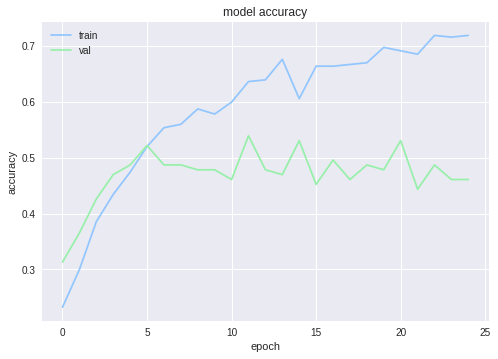

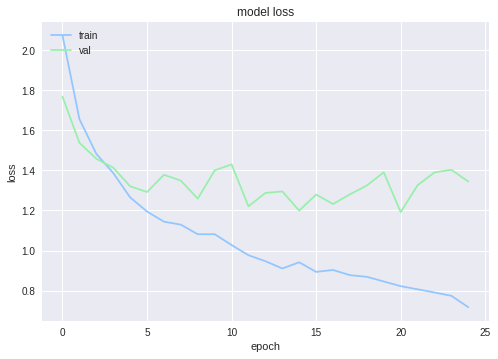

In [0]:
show_graphs(training_e)

In [0]:
predictions = model_e.predict_generator(test_batches_e, steps=7, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches_e.classes
agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.38571428571428573

In [0]:
score = model_e.evaluate_generator(test_batches_e, steps=7, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 1.6741199067660741
Test accuracy: 0.3857142946549824
************************************************************


Confusion matrix, without normalization
[[ 8  0  0  1  3]
 [ 7 11  0  2  2]
 [ 4  1  0  2  1]
 [ 8  1  1  4  4]
 [ 3  1  1  1  4]]
Normalized confusion matrix
[[0.66666667 0.         0.         0.08333333 0.25      ]
 [0.31818182 0.5        0.         0.09090909 0.09090909]
 [0.5        0.125      0.         0.25       0.125     ]
 [0.44444444 0.05555556 0.05555556 0.22222222 0.22222222]
 [0.3        0.1        0.1        0.1        0.4       ]]


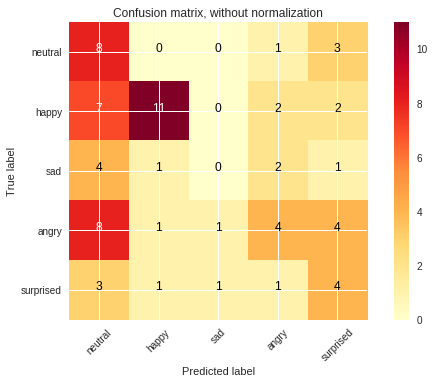

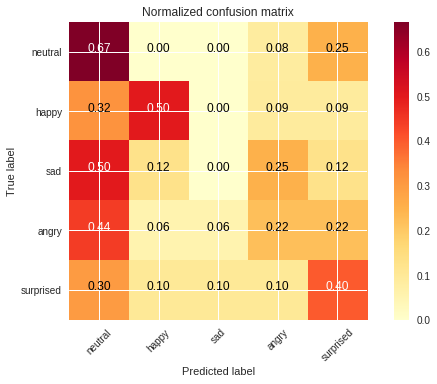

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

class_names = ['neutral', 'happy', 'sad', 'angry', 'surprised']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

    neutral       0.27      0.67      0.38        12
      happy       0.79      0.50      0.61        22
        sad       0.00      0.00      0.00         8
      angry       0.40      0.22      0.29        18
  surprised       0.29      0.40      0.33        10

avg / total       0.44      0.39      0.38        70



### Discussion of Results

Here the results are slightly better, at 50%, but the reintroduction of the scraped images does not seem to have helped with the neutral images. Thus the next run was done on a dataset stripped of the neutral images, to see whether that would improve the accuracy.

### No Neutral Faces

In [0]:
# Define training, validation and test data paths
train_path_e = '/content/drive/My Drive/app/emotionType/trainAllr/'
test_path_e = '/content/drive/My Drive/app/emotionType/testAllr/'
valid_path_e = '/content/drive/My Drive/app/emotionType/valAllr/'

# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches_e = train_datagen.flow_from_directory(train_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
valid_batches_e = ImageDataGenerator().flow_from_directory(valid_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
test_batches_e = ImageDataGenerator().flow_from_directory(test_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=False)

Found 272 images belonging to 4 classes.
Found 97 images belonging to 4 classes.
Found 58 images belonging to 4 classes.


In [0]:
vgg16Model = keras.applications.vgg16.VGG16()

In [0]:
num_classes = 4
model_e = Sequential()

for layer in vgg16Model.layers[:-1]:
  model_e.add(layer)

for layer in model_e.layers:
  layer.trainable = False
model_e.add(Dense(num_classes,activation='softmax'))
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
model_e.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training_e = model_e.fit_generator(train_batches_e, steps_per_epoch=28,
                   validation_data=valid_batches_e,
                   validation_steps=10, epochs=30,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/30
 - 7s - loss: 1.8162 - acc: 0.2610 - val_loss: 1.7661 - val_acc: 0.2577
Epoch 2/30
 - 6s - loss: 1.4722 - acc: 0.3350 - val_loss: 1.5099 - val_acc: 0.3505
Epoch 3/30
 - 6s - loss: 1.3192 - acc: 0.3897 - val_loss: 1.3968 - val_acc: 0.3608
Epoch 4/30
 - 6s - loss: 1.2181 - acc: 0.4642 - val_loss: 1.3178 - val_acc: 0.3918
Epoch 5/30
 - 6s - loss: 1.1216 - acc: 0.5138 - val_loss: 1.2849 - val_acc: 0.4742
Epoch 6/30
 - 6s - loss: 1.1179 - acc: 0.5036 - val_loss: 1.2409 - val_acc: 0.4536
Epoch 7/30
 - 6s - loss: 1.0287 - acc: 0.5889 - val_loss: 1.2761 - val_acc: 0.4536
Epoch 8/30
 - 6s - loss: 0.9773 - acc: 0.5924 - val_loss: 1.2361 - val_acc: 0.4742
Epoch 9/30
 - 6s - loss: 0.9884 - acc: 0.5822 - val_loss: 1.1718 - val_acc: 0.5052
Epoch 10/30
 - 6s - loss: 0.9218 - acc: 0.6256 - val_loss: 1.1735 - val_acc: 0.5052
Epoch 11/30
 - 6s - loss: 0.9612 - acc: 0.6042 - val_loss: 1.1115 - val_acc: 0.5876
Epoch 12/30
 - 6s - loss: 0.9067 - acc: 0.6108 - val_loss: 1.1380 - val_acc: 0.5361
E

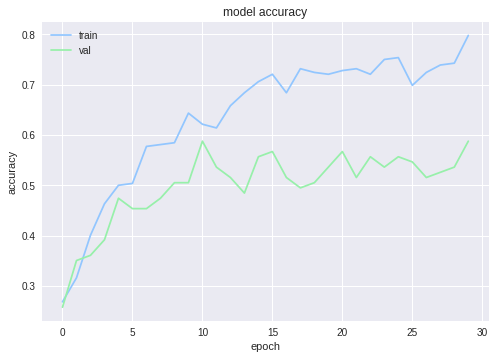

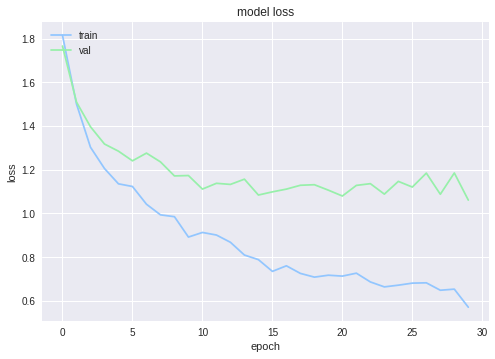

In [0]:
show_graphs(training_e)

In [0]:
predictions = model_e.predict_generator(test_batches_e, steps=6, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches_e.classes
agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.5689655172413793

In [0]:
score = model_e.evaluate_generator(test_batches_e, steps=6, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 1.146335312004747
Test accuracy: 0.5689655156998799
************************************************************


Confusion matrix, without normalization
[[15  0  5  2]
 [ 1  1  6  0]
 [ 3  0 12  3]
 [ 2  0  3  5]]
Normalized confusion matrix
[[0.68181818 0.         0.22727273 0.09090909]
 [0.125      0.125      0.75       0.        ]
 [0.16666667 0.         0.66666667 0.16666667]
 [0.2        0.         0.3        0.5       ]]


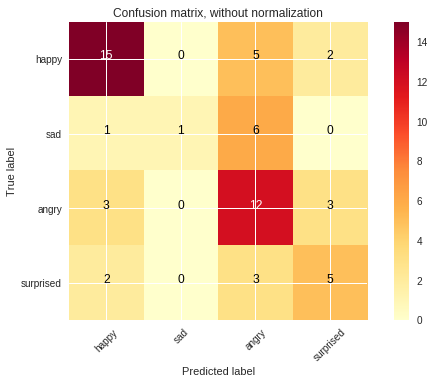

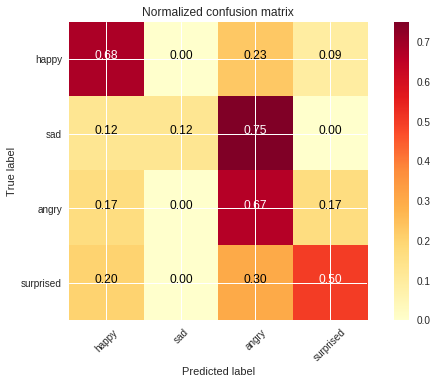

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

class_names = ['happy', 'sad', 'angry', 'surprised']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

      happy       0.71      0.68      0.70        22
        sad       1.00      0.12      0.22         8
      angry       0.46      0.67      0.55        18
  surprised       0.50      0.50      0.50        10

avg / total       0.64      0.57      0.55        58



### Discussion of Results

Removing the neutral faces has not improved overall accuracy by much. Precision and accuracy for the various classes seem to change without much discernible pattern. We then tried the same classification problem with the VGG19 model, a similar deep learning model with, as the name suggests, 19 layers.

### VGG19

In [0]:
# Define training, validation and test data paths
train_path_e = '/content/drive/My Drive/app/emotionType/trainAllr/'
test_path_e = '/content/drive/My Drive/app/emotionType/testAllr/'
valid_path_e = '/content/drive/My Drive/app/emotionType/valAllr/'

# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches_e = train_datagen.flow_from_directory(train_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
valid_batches_e = ImageDataGenerator().flow_from_directory(valid_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
test_batches_e = ImageDataGenerator().flow_from_directory(test_path_e, target_size=(224,224),classes=
                                                             ['1','2','3','4'],
                                                            batch_size=10, shuffle=False)

Found 272 images belonging to 4 classes.
Found 97 images belonging to 4 classes.
Found 58 images belonging to 4 classes.


In [0]:
vgg19Model = keras.applications.vgg19.VGG19()

574717952/574710816 [==============================] - 7s 0us/step


In [0]:
num_classes = 4
model_e = Sequential()

for layer in vgg19Model.layers[:-1]:
  model_e.add(layer)

for layer in model_e.layers:
  layer.trainable = False
model_e.add(Dense(num_classes,activation='softmax'))
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
model_e.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training_e = model_e.fit_generator(train_batches_e, steps_per_epoch=28,
                   validation_data=valid_batches_e,
                   validation_steps=10, epochs=30,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/30
 - 7s - loss: 1.6869 - acc: 0.3320 - val_loss: 1.4343 - val_acc: 0.4742
Epoch 2/30
 - 6s - loss: 1.4206 - acc: 0.4076 - val_loss: 1.3621 - val_acc: 0.5155
Epoch 3/30
 - 6s - loss: 1.2101 - acc: 0.4785 - val_loss: 1.3081 - val_acc: 0.5361
Epoch 4/30
 - 6s - loss: 1.1741 - acc: 0.4964 - val_loss: 1.2588 - val_acc: 0.5670
Epoch 5/30
 - 6s - loss: 1.0764 - acc: 0.5536 - val_loss: 1.2229 - val_acc: 0.5258
Epoch 6/30
 - 6s - loss: 1.0866 - acc: 0.5358 - val_loss: 1.2103 - val_acc: 0.5567
Epoch 7/30
 - 6s - loss: 1.0172 - acc: 0.5822 - val_loss: 1.1920 - val_acc: 0.5258
Epoch 8/30
 - 6s - loss: 0.8955 - acc: 0.6532 - val_loss: 1.1766 - val_acc: 0.5464
Epoch 9/30
 - 6s - loss: 0.9146 - acc: 0.6144 - val_loss: 1.1528 - val_acc: 0.5567
Epoch 10/30
 - 6s - loss: 0.8208 - acc: 0.6496 - val_loss: 1.1953 - val_acc: 0.5258
Epoch 11/30
 - 6s - loss: 0.8500 - acc: 0.6496 - val_loss: 1.1850 - val_acc: 0.5155
Epoch 12/30
 - 6s - loss: 0.8411 - acc: 0.6389 - val_loss: 1.1112 - val_acc: 0.5155
E

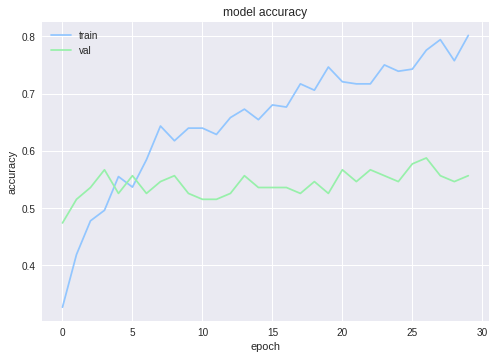

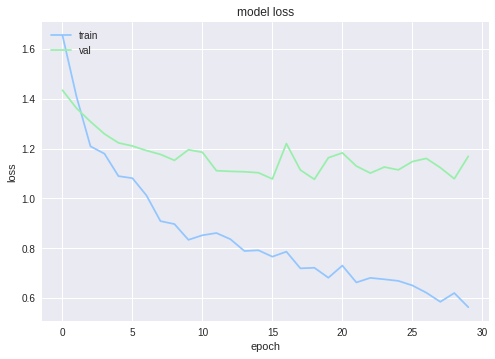

In [0]:
show_graphs(training_e)

In [0]:
predictions = model_e.predict_generator(test_batches_e, steps=6, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches_e.classes

agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.5344827586206896

In [0]:
score = model_e.evaluate_generator(test_batches_e, steps=6, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 1.1978706018678074
Test accuracy: 0.5344827691542691
************************************************************


Confusion matrix, without normalization
[[15  1  2  4]
 [ 1  0  6  1]
 [ 2  3  9  4]
 [ 1  0  2  7]]
Normalized confusion matrix
[[0.68181818 0.04545455 0.09090909 0.18181818]
 [0.125      0.         0.75       0.125     ]
 [0.11111111 0.16666667 0.5        0.22222222]
 [0.1        0.         0.2        0.7       ]]


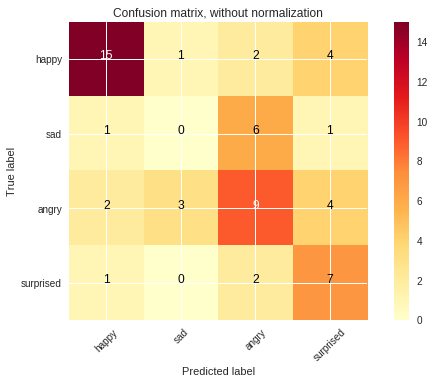

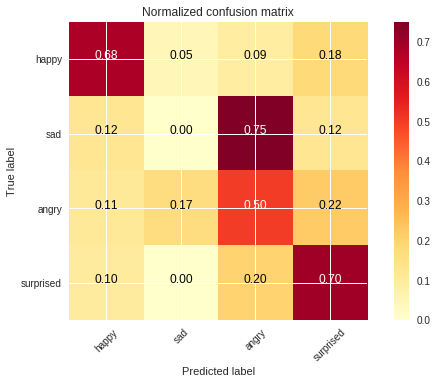

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

class_names = ['happy', 'sad', 'angry', 'surprised']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

      happy       0.79      0.68      0.73        22
        sad       0.00      0.00      0.00         8
      angry       0.47      0.50      0.49        18
  surprised       0.44      0.70      0.54        10

avg / total       0.52      0.53      0.52        58



### Discussion of Results

Using the VGG19 model has led to a slight reduction in accuracy, to 53%. As with earlier runs, the model seems to perform best with happy expressions, whereas results are less impressive on the sad, surprised and angry images. 

### Angry and Sad Faces Only, VGG16

In [29]:
# Define training, validation and test data paths
train_path_e = '/content/drive/My Drive/app/emotionType/trainAlls/'
test_path_e = '/content/drive/My Drive/app/emotionType/testAlls/'
valid_path_e = '/content/drive/My Drive/app/emotionType/valAlls/'

# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=3, width_shift_range=0.1,
                                  height_shift_range=0.1,shear_range=0.15,
                                  zoom_range=0.1, channel_shift_range=10,
                                  horizontal_flip=True)

train_batches_e = train_datagen.flow_from_directory(train_path_e, target_size=(224,224),classes=
                                                             ['1','3'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
valid_batches_e = ImageDataGenerator().flow_from_directory(valid_path_e, target_size=(224,224),classes=
                                                             ['1','3'],
                                                            batch_size=10, shuffle=True, class_mode='categorical')
test_batches_e = ImageDataGenerator().flow_from_directory(test_path_e, target_size=(224,224),classes=
                                                             ['1','3'],
                                                            batch_size=10, shuffle=False)

Found 166 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [0]:
vgg16Model = keras.applications.vgg16.VGG16()

In [32]:
num_classes = 2
model_e = Sequential()

for layer in vgg16Model.layers[:-1]:
  model_e.add(layer)

for layer in model_e.layers:
  layer.trainable = False
model_e.add(Dense(num_classes,activation='softmax'))
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
model_e.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(optimizer=keras.optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model_e.compile(RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
training_e = model_e.fit_generator(train_batches_e, steps_per_epoch=17,
                   validation_data=valid_batches_e,
                   validation_steps=6, epochs=100,
                   verbose=2, callbacks=[lr_reducer, tensorboard])

Epoch 1/100
 - 5s - loss: 0.9993 - acc: 0.4956 - val_loss: 0.9709 - val_acc: 0.5370
Epoch 2/100
 - 4s - loss: 0.7792 - acc: 0.6038 - val_loss: 0.7741 - val_acc: 0.5556
Epoch 3/100
 - 4s - loss: 0.5919 - acc: 0.6900 - val_loss: 0.7390 - val_acc: 0.5370
Epoch 4/100
 - 4s - loss: 0.5890 - acc: 0.6944 - val_loss: 0.6912 - val_acc: 0.6667
Epoch 5/100
 - 4s - loss: 0.5083 - acc: 0.7297 - val_loss: 0.6811 - val_acc: 0.6667
Epoch 6/100
 - 4s - loss: 0.4709 - acc: 0.8196 - val_loss: 0.6615 - val_acc: 0.6667
Epoch 7/100
 - 4s - loss: 0.4637 - acc: 0.7821 - val_loss: 0.6756 - val_acc: 0.6667
Epoch 8/100
 - 4s - loss: 0.4810 - acc: 0.7688 - val_loss: 0.6426 - val_acc: 0.7037
Epoch 9/100
 - 4s - loss: 0.4318 - acc: 0.7747 - val_loss: 0.7696 - val_acc: 0.5926
Epoch 10/100
 - 4s - loss: 0.4230 - acc: 0.8115 - val_loss: 0.6526 - val_acc: 0.7778
Epoch 11/100
 - 4s - loss: 0.4395 - acc: 0.7703 - val_loss: 0.6461 - val_acc: 0.6852
Epoch 12/100
 - 4s - loss: 0.4540 - acc: 0.7725 - val_loss: 0.6224 - val_a

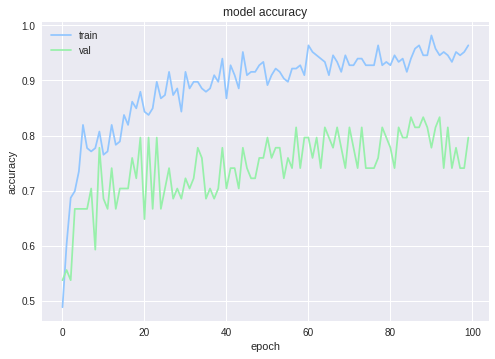

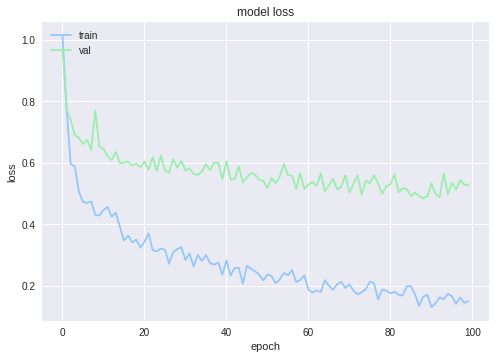

In [35]:
show_graphs(training_e)

In [36]:
predictions = model_e.predict_generator(test_batches_e, steps=6, verbose=0)

y_pred = []
for element in predictions:
  y_pred.append(list(element).index(max(element)))

y_test = test_batches_e.classes
agreement = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_test))]
sum(agreement) / len(agreement)

0.7678571428571429

In [37]:
score = model_e.evaluate_generator(test_batches_e, steps=6, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])
  
print('*' * 60)

Test loss: 0.5594052837363311
Test accuracy: 0.7678571407284055
************************************************************


Confusion matrix, without normalization
[[24  5]
 [ 8 19]]
Normalized confusion matrix
[[0.82758621 0.17241379]
 [0.2962963  0.7037037 ]]


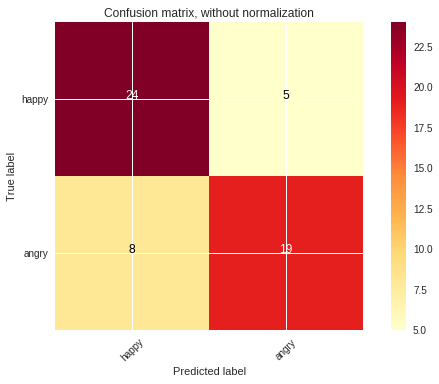

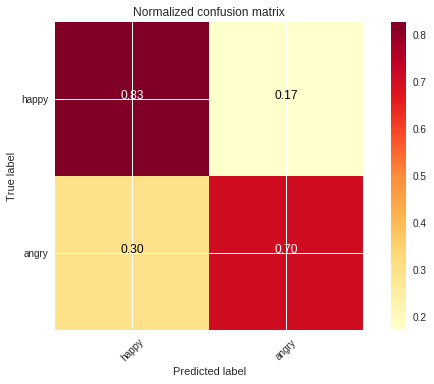

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

class_names = ['happy', 'angry']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

      happy       0.75      0.83      0.79        29
      angry       0.79      0.70      0.75        27

avg / total       0.77      0.77      0.77        56



### Discussion of Results

Thus the accuracy in this head-to-head matchup between angry and happy expressions is around 3/4. The happy/smilling faces chosen were primarily ones with no teeth showing, to eliminate the possibility of the model picking up the subject's teeth. The accuracy is therefore possibly lower than it might have been if this measure had not been taken.

## Conclusions


---


![alt text](https://static.thenounproject.com/png/113911-200.png)
---

* The pre-trained VGG16 and VGG19 models can successfully be applied to sex-recognition and, to a lesser extent, facial-expression-rcognition datasets.
* Best accuracy obtained in sex classification: 90.0%.
* Best accuracy obtained in facial-expression classification, with 4 classes: 56.9%
* Best accuracy obtained in facial-expression classification, with 2 classes: 76.8%
* The changes resulting from measures taken (such as the removal of the neutral class) did not seem to follow any predictable pattern.






### Directions for Further Study

* Explore the use of other pre-trained models to improve accuracy.
* Perhaps re-train model on more extreme exemplars of each facial expression, i.e. use only the brightest smiles or the angriest faces, to see how more extreme expressions may help the model to learn more effectively.